In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
import inception

In [19]:
inception.data_dir = 'inception/'
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [20]:
model = inception.Inception()
resized_image = model.resized_image
y_pred = model.y_pred
y_logits = model.y_logits

Instructions for updating:
Use tf.gfile.GFile.


In [0]:
with model.graph.as_default():
    # Add a placeholder variable for the target class-number.
    # This will be set to e.g. 300 for the 'bookcase' class.
    pl_cls_target = tf.placeholder(dtype=tf.int32)

    # Add a new loss-function. This is the cross-entropy.
    # See Tutorial #01 for an explanation of cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])

    # Get the gradient for the loss-function with regard to
    # the resized input image.
    gradient = tf.gradients(loss, resized_image)

In [0]:
session = tf.Session(graph=model.graph)

In [0]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0,
                         required_score=0.99, max_iterations=100):
    """
    Find the noise that must be added to the given image so
    that it is classified as the target-class.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    max_iterations: Max number of optimization iterations to perform.
    """

    feed_dict = model._create_feed_dict(image_path=image_path)

    pred, image = session.run([y_pred, resized_image],
                              feed_dict=feed_dict)

    pred = np.squeeze(pred)

    cls_source = np.argmax(pred)

    score_source_org = pred.max()

    name_source = model.name_lookup.cls_to_name(cls_source,
                                                only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target,
                                                only_first_name=True)

    noise = 0

    for i in range(max_iterations):
        print("Iteration:", i)

        noisy_image = image + noise

        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)

        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}

        pred, grad = session.run([y_pred, gradient],
                                 feed_dict=feed_dict)

        pred = np.squeeze(pred)

        score_source = pred[cls_source]
        score_target = pred[cls_target]

        grad = np.array(grad).squeeze()


        grad_absmax = np.abs(grad).max()
        
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10

        step_size = 7 / grad_absmax

        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        print()

        if score_target < required_score:
            noise -= step_size * grad

            noise = np.clip(a=noise,
                            a_min=-noise_limit,
                            a_max=noise_limit)
        else:
            break

    return image.squeeze(), noisy_image.squeeze(), noise, \
           name_source, name_target, \
           score_source, score_source_org, score_target

In [0]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

In [0]:
def plot_images(image, noise, noisy_image,
                name_source, name_target,
                score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    smooth = True
    
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [0]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    image, noisy_image, noise, \
    name_source, name_target, \
    score_source, score_source_org, score_target = \
        find_adversary_noise(image_path=image_path,
                             cls_target=cls_target,
                             noise_limit=noise_limit,
                             required_score=required_score)

    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

Iteration: 0
Source score:  97.18%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  322, class-name: pineapple
Gradient min: -0.002166, max:  0.002542, stepsize:   2753.38

Iteration: 1
Source score:  84.33%, class-number:  409, class-name: macaw
Target score:   0.02%, class-number:  322, class-name: pineapple
Gradient min: -0.001265, max:  0.001441, stepsize:   4858.01

Iteration: 2
Source score:  49.10%, class-number:  409, class-name: macaw
Target score:   0.12%, class-number:  322, class-name: pineapple
Gradient min: -0.001670, max:  0.001809, stepsize:   3869.07

Iteration: 3
Source score:  39.36%, class-number:  409, class-name: macaw
Target score:   0.34%, class-number:  322, class-name: pineapple
Gradient min: -0.001059, max:  0.000968, stepsize:   6607.46

Iteration: 4
Source score:  22.01%, class-number:  409, class-name: macaw
Target score:   4.47%, class-number:  322, class-name: pineapple
Gradient min: -0.002558, max:  0.002385, stepsize:   2736

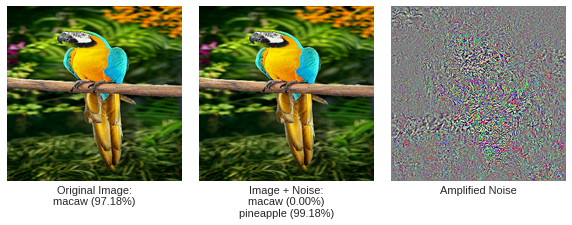

Noise min: -3.000, max: 3.000, mean: -0.000, std: 0.949


In [37]:
image_path = "parrot.jpg"

adversary_example(image_path=image_path,
                  cls_target=322,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration: 0
Source score:  16.63%, class-number:  837, class-name: sweatshirt
Target score:   0.06%, class-number:  260, class-name: motor scooter
Gradient min: -0.006171, max:  0.007220, stepsize:    969.48

Iteration: 1
Source score:   0.37%, class-number:  837, class-name: sweatshirt
Target score:   1.09%, class-number:  260, class-name: motor scooter
Gradient min: -0.008271, max:  0.009775, stepsize:    716.13

Iteration: 2
Source score:   0.18%, class-number:  837, class-name: sweatshirt
Target score:  58.43%, class-number:  260, class-name: motor scooter
Gradient min: -0.003392, max:  0.004077, stepsize:   1716.75

Iteration: 3
Source score:   0.01%, class-number:  837, class-name: sweatshirt
Target score:  82.30%, class-number:  260, class-name: motor scooter
Gradient min: -0.001012, max:  0.001092, stepsize:   6411.63

Iteration: 4
Source score:   0.27%, class-number:  837, class-name: sweatshirt
Target score:  37.12%, class-number:  260, class-name: motor scooter
Gradient min

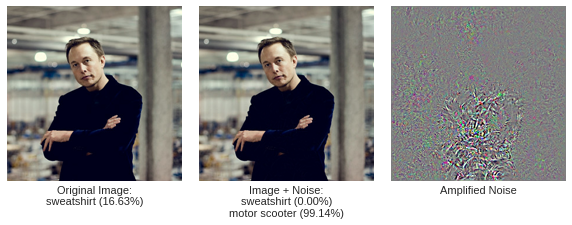

Noise min: -3.000, max: 3.000, mean: -0.003, std: 0.612


In [38]:
image_path = "elon_musk.jpg"

adversary_example(image_path=image_path,
                  cls_target=260,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration: 0
Source score:  70.98%, class-number:   76, class-name: tiger
Target score:   0.01%, class-number:  560, class-name: joystick
Gradient min: -0.000727, max:  0.000818, stepsize:   8555.00

Iteration: 1
Source score:  50.83%, class-number:   76, class-name: tiger
Target score:   0.06%, class-number:  560, class-name: joystick
Gradient min: -0.000821, max:  0.000641, stepsize:   8528.76

Iteration: 2
Source score:  38.76%, class-number:   76, class-name: tiger
Target score:   0.13%, class-number:  560, class-name: joystick
Gradient min: -0.001146, max:  0.000807, stepsize:   6108.01

Iteration: 3
Source score:  33.30%, class-number:   76, class-name: tiger
Target score:   0.22%, class-number:  560, class-name: joystick
Gradient min: -0.000651, max:  0.000617, stepsize:  10753.05

Iteration: 4
Source score:  30.67%, class-number:   76, class-name: tiger
Target score:   0.23%, class-number:  560, class-name: joystick
Gradient min: -0.001022, max:  0.000880, stepsize:   6848.63



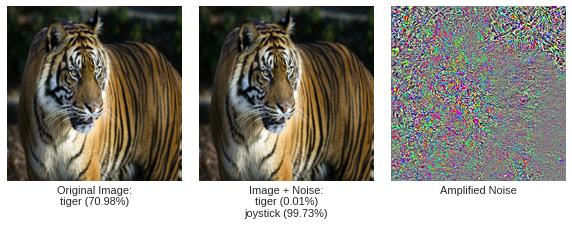

Noise min: -3.000, max: 3.000, mean: -0.001, std: 1.220


In [45]:
image_path = "tiger.jpg"

adversary_example(image_path=image_path,
                  cls_target=560,
                  noise_limit=3.0,
                  required_score=0.99)